In [1]:
from SPARQLWrapper import SPARQLWrapper, JSON
import matplotlib.pyplot as plt
import datetime

Function that sends a SPARQL query to the OfficeKG endpoint, that returns the bindings of the query.

In [2]:
def query_ic_graph(query, bind):
    if not isinstance(bind, list):
        bind = [bind]
    sparql = SPARQLWrapper(
#         "http://130.37.53.36:6789/sparql"
        "https://data.interconnect.labs.vu.nl/sparql"
    )
    sparql.setReturnFormat(JSON)

    sparql.setQuery(query)

    all_res = {}
    try:
        ret = sparql.queryAndConvert()
    #     print("ret:", ret)
        for b in bind:
            res = []
            for r in ret["results"]["bindings"]:
    #             print(r[bind]["value"])
                res.append(r[b]["value"])
            all_res[b] = res
    except Exception as e:
        print(e)
    if len(all_res.keys()) == 1:
        return all_res[bind[0]]
    return all_res

QUERY: Get all rooms and timestamps from devices measuring property x

In [3]:
q_get_all_room_time_for_property = """
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX saref: <https://saref.etsi.org/core/>
    PREFIX ic: <https://interconnectproject.eu/example/>
    PREFIX s4bldg: <https://saref.etsi.org/saref4bldg/>

SELECT DISTINCT ?room1 ?time1 WHERE {{
  ?dev1 saref:measuresProperty ?pred1 .
  ?pred1 a {} .
  ?dev1 s4bldg:isContainedIn ?room1 .
  ?dev1 saref:makesMeasurement ?meas1 .
  ?meas1 saref:relatesToProperty ?pred1 .
  ?meas1 saref:hasTimestamp ?time1 .
}}
"""

create a dictionary where each key is a device_name, with another dict as item containing the values ("val") and timestamps ("time") of its measurements.

Based on query results shaped \[device_name, measurement_time, measurement_value\]

In [4]:
def make_dict_dev_val_time(query_results, dev_key="dev1", val_key="val1", time_key="time1"):
    dev_dict = {}
    for dev, val, time in zip(query_results[dev_key], query_results[val_key], query_results[time_key]):
#         print(dev, val, time)
        val = float(val)
        try:
            dev_dict[dev]["val"].append(val)
            dev_dict[dev]["time"].append(time)
        except:
            dev_dict[dev] = {}
            dev_dict[dev]["val"] = [val]
            dev_dict[dev]["time"] = [time]
    return dev_dict

In [5]:
def make_room_time_dict(query_results, room_key="room1", time_key="time1"):
    room_dict = {}
    for room, time in zip(query_results[room_key], query_results[time_key]):
        try:
            room_dict[room]["time"].append(time)
        except:
            room_dict[room] = {}
            room_dict[room]["time"] = [time]
    return room_dict

helper functions for datetime objects

In [6]:
def datetime_from_str(list_of_strings):
    times = []
    for t in list_of_strings:
        times.append(datetime.datetime.strptime(t, '%Y-%m-%dT%H:%M:%S'))
    return times

def float_from_str(list_of_strings):
    floats = []
    for t in list_of_strings:
        floats.append(float(t))
    return floats

variables and functions used when plotting the figures

In [7]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
colors += ['b', 'g', 'r']
max_temp = 36
min_temp = 10
                        
delta_days = 1                        #IMPORTANT!!
time_delta = datetime.timedelta(days=delta_days)

def make_dev_color_dict(devs):
    dev_c_dict = {}
    if len(colors) < len(devs):
        print("TOO FEW COLORS!!!")
        exit()
    for dev, c in zip(devs, colors):
        dev_c_dict[dev] = c
    return dev_c_dict

def unique_devices_in_room_dev_dict(rooms_dev_dict):
    all_devices = []
    for room_key in rooms_dev_dict.keys():
#        print(room_key)
        for time_key in rooms_dev_dict[room_key].keys():
            for dev_key in rooms_dev_dict[room_key][time_key].keys():
#                print(dev_key)
                all_devices.append(dev_key)
    all_devices = list(set(all_devices))
    print("this dict contains", len(all_devices), "unique devices.")
    return all_devices


QUERY: For a given: device_name, property and time range, return all measurements about the given property made in the same room as the device_name, within a time range

In [8]:
q_get_meas_of_prop_on_room_around_time = """
 PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
 PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
 PREFIX s4ener: <https://saref.etsi.org/saref4ener/>
 PREFIX s4bldg: <https://saref.etsi.org/saref4bldg/>
 PREFIX saref: <https://saref.etsi.org/core/>
 PREFIX ic: <https://interconnectproject.eu/example/>

 SELECT DISTINCT ?dev ?time ?val WHERE {{
  ?dev s4bldg:isContainedIn <{}> .
  ?dev saref:measuresProperty ?pred .
  ?pred a {} .
  ?dev saref:makesMeasurement ?meas .
  ?meas saref:relatesToProperty ?pred .
  ?meas saref:hasTimestamp ?time .
  ?meas saref:hasValue ?val .
  FILTER ( ?time >= '{}'^^xsd:dateTime && ?time <= '{}'^^xsd:dateTime )  
}}
"""

### Visualization of the Data

Query for thermostat rooms and times (returning rooms, measurement_time)

In [9]:
all_thermos_room_times = query_ic_graph(q_get_all_room_time_for_property.format("ic:thermostatHeatingSetpoint"), ["room1", "time1"])


In [10]:
thermos_room_dict = make_room_time_dict(all_thermos_room_times, "room1", "time1")

In [11]:
def query_for_meas_on_room_prop(room_time_dict, property_type):
    rooms_all_meas_dict = {}
    room_keys = list(room_time_dict.keys())
    for room_key in room_keys:
        all_meas = {}
        print("Starting on room:", room_key[-10:])
        times = datetime_from_str(room_time_dict[room_key]["time"])
        for time in times:
            time_start = time - time_delta
            time_stop = time + time_delta
            time_start = time_start.strftime('%Y-%m-%dT%H:%M:%S')
            time_stop = time_stop.strftime('%Y-%m-%dT%H:%M:%S')
            query_result = query_ic_graph(q_get_meas_of_prop_on_room_around_time.format(room_key, property_type, time_start, time_stop), ["dev", "time", "val"])
            #print(query_result)
            all_meas[time] = make_dict_dev_val_time(query_result, dev_key="dev", val_key="val", time_key="time")
        rooms_all_meas_dict[room_key] = all_meas
    return rooms_all_meas_dict


In [ ]:
rooms_all_contact_dict = query_for_meas_on_room_prop(thermos_room_dict, "ic:Contact")

In [ ]:
rooms_all_thermos_dict = query_for_meas_on_room_prop(thermos_room_dict, "ic:thermostatHeatingSetpoint")

In [14]:
rooms_all_temps_dict = query_for_meas_on_room_prop(thermos_room_dict, "saref:Temperature")

Starting on room: c9067a220f
Starting on room: name_3.009
Starting on room: -F3-04-T41
Starting on room: 0190046a12
Starting on room: 53e4b23e32
Starting on room: -WEST-T-39
Starting on room: mname_3.01
Starting on room: -F3-04-T42
Starting on room: -WEST-T-38
Starting on room: 54b2c3ab77
Starting on room: name_7.022
Starting on room: F7-O3-T18a
Starting on room: be86f38a4b
Starting on room: -F6-O4-T52
Starting on room: -OOST-T-20
Starting on room: d9c481c9fe
Starting on room: mname_3.02
Starting on room: -F3-O3-T11


In [18]:
all_contact_devices = unique_devices_in_room_dev_dict(rooms_all_contact_dict)
contact_color_dict = make_dev_color_dict(all_contact_devices)

all_thermos_devices = unique_devices_in_room_dev_dict(rooms_all_thermos_dict)
thermos_color_dict = make_dev_color_dict(all_thermos_devices)


this dict contains 13 unique devices.
this dict contains 11 unique devices.


In [19]:
def add_meas_state(dev_dict, lines=None, color_dict=[], lines_str=""):
    for dev_key in dev_dict.keys():
        if lines != None:
            lines.append(dev_key.replace("https://interconnectproject.eu/example/", "ic:")+lines_str)
        vals = dev_dict[dev_key]["val"]
        times = dev_dict[dev_key]["time"]
        times = datetime_from_str(times)
        if not color_dict == []: use_color = color_dict[dev_key]
        else: use_color = "tab:blue"
        for t, v in zip(times, vals):
            if v == 1:
                plt.plot([t,t], [((max_temp+min_temp)*(7/16)), max_temp], marker='v', c=color_dict[dev_key], zorder=10)
            else:
                plt.plot([t,t], [min_temp, ((max_temp+min_temp)*(9/16))], marker='^', c=color_dict[dev_key], zorder=10)
    return lines
                
def add_meas_scatter(dev_dict, lines=None, color_dict=[], lines_str=""):
    for dev_key in dev_dict.keys():
        if lines != None:
            lines.append(dev_key.replace("https://interconnectproject.eu/example/", "ic:")+lines_str)
        if not color_dict == []: use_color = color_dict[dev_key]
        else: use_color = "tab:green"
        vals = dev_dict[dev_key]["val"]
        times = dev_dict[dev_key]["time"]
        times = datetime_from_str(times)
        plt.scatter(times, vals, c=use_color, s=50, zorder=100)
    return lines
        
def add_meas_line(dev_dict, lines=None, color_dict=[], lines_str=""):
    for dev_key in dev_dict.keys():
        if lines != None:
            lines.append(dev_key.replace("https://interconnectproject.eu/example/", "ic:")+lines_str)
        if not color_dict == []: use_color = color_dict[dev_key]
        else: use_color = "gainsboro"
        vals = dev_dict[dev_key]["val"]
        times = dev_dict[dev_key]["time"]
        vals = [x for _, x in sorted(zip(times, vals))]
        times = sorted(times)
        times = datetime_from_str(times)
        plt.plot(times, vals, c=use_color, zorder=1)
    return lines

https://interconnectproject.eu/example/room_urn-Room-SmartThings-ed73d598-b9ed-4448-9ece-e553e4b23e32


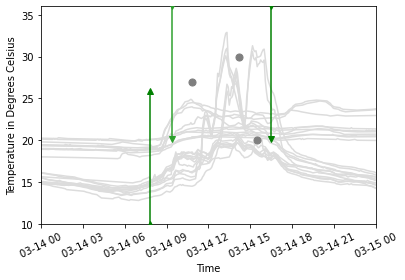

In [20]:
legend_lines = []
only1 = ["https://interconnectproject.eu/example/room_urn-Room-SmartThings-ed73d598-b9ed-4448-9ece-e553e4b23e32"]
# for room_key in thermos_room_dict.keys():
for room_key in only1:
    print(room_key)
    i = 0
    for time_key in thermos_room_dict[room_key]["time"]:
        i+= 1
        if i < 13:
            continue
        elif i >13:
            continue
        time_key = datetime.datetime.strptime(time_key, '%Y-%m-%dT%H:%M:%S')
        if len(rooms_all_contact_dict[room_key][time_key].keys()) == 0: continue
        if len(rooms_all_thermos_dict[room_key][time_key].keys()) == 0: continue
        if len(rooms_all_temps_dict[room_key][time_key].keys()) == 0: continue
        legend_lines = add_meas_line(rooms_all_temps_dict[room_key][time_key], legend_lines, lines_str="_Temperature")
        legend_lines = add_meas_state(rooms_all_contact_dict[room_key][time_key], legend_lines, contact_color_dict, lines_str="_Contact")
        legend_lines = add_meas_scatter(rooms_all_thermos_dict[room_key][time_key], legend_lines, thermos_color_dict, lines_str="_Thermostat")
        plt.xticks( rotation=25 )
        start_time = time_key-datetime.timedelta(hours=time_key.hour, minutes=time_key.minute, seconds=time_key.second)
        end_time = start_time+datetime.timedelta(hours=24)
        plt.xlim(start_time, end_time)
        plt.ylim(min_temp, max_temp)
        plt.ylabel("Temperature in Degrees Celsius")
        plt.xlabel("Time")
#         plt.legend(legend_lines, bbox_to_anchor=(1, 0.5))
#         plt.show()
        plt.savefig('windows.eps', format='eps', bbox_inches="tight")

## Thermostat turned down within 30 minutes after window opening:

In [21]:
minutes_delta = datetime.timedelta(minutes=30)


In [22]:
def query_for_meas_on_room_prop_time_before(room_time_dict, property_type, minutes_delta):
    rooms_all_meas_dict = {}
    room_keys = list(room_time_dict.keys())
    for room_key in room_keys:
        all_meas = {}
        print("Starting on room:", room_key[-10:])
        times = datetime_from_str(room_time_dict[room_key]["time"])
        for time in times:
            time_start = time - minutes_delta
            time_stop = time
            time_start = time_start.strftime('%Y-%m-%dT%H:%M:%S')
            time_stop = time_stop.strftime('%Y-%m-%dT%H:%M:%S')
            query_result = query_ic_graph(q_get_meas_of_prop_on_room_around_time.format(room_key, property_type, time_start, time_stop), ["dev", "time", "val"])
            #print(query_result)
            all_meas[time] = make_dict_dev_val_time(query_result, dev_key="dev", val_key="val", time_key="time")
        rooms_all_meas_dict[room_key] = all_meas
    return rooms_all_meas_dict

In [23]:
rooms_all_contact_dict = query_for_meas_on_room_prop_time_before(thermos_room_dict, "ic:Contact", minutes_delta)

Starting on room: c9067a220f
Starting on room: name_3.009
Starting on room: -F3-04-T41
Starting on room: 0190046a12
Starting on room: 53e4b23e32
Starting on room: -WEST-T-39
Starting on room: mname_3.01
Starting on room: -F3-04-T42
Starting on room: -WEST-T-38
Starting on room: 54b2c3ab77
Starting on room: name_7.022
Starting on room: F7-O3-T18a
Starting on room: be86f38a4b
Starting on room: -F6-O4-T52
Starting on room: -OOST-T-20
Starting on room: d9c481c9fe
Starting on room: mname_3.02
Starting on room: -F3-O3-T11


In [24]:
rooms_all_thermos_dict = query_for_meas_on_room_prop_time_before(thermos_room_dict, "ic:thermostatHeatingSetpoint", minutes_delta)


Starting on room: c9067a220f
Starting on room: name_3.009
Starting on room: -F3-04-T41
Starting on room: 0190046a12
Starting on room: 53e4b23e32
Starting on room: -WEST-T-39
Starting on room: mname_3.01
Starting on room: -F3-04-T42
Starting on room: -WEST-T-38
Starting on room: 54b2c3ab77
Starting on room: name_7.022
Starting on room: F7-O3-T18a
Starting on room: be86f38a4b
Starting on room: -F6-O4-T52
Starting on room: -OOST-T-20
Starting on room: d9c481c9fe
Starting on room: mname_3.02
Starting on room: -F3-O3-T11


In [25]:
rooms_all_temps_dict = query_for_meas_on_room_prop_time_before(thermos_room_dict, "saref:Temperature", minutes_delta)

Starting on room: c9067a220f
Starting on room: name_3.009
Starting on room: -F3-04-T41
Starting on room: 0190046a12
Starting on room: 53e4b23e32
Starting on room: -WEST-T-39
Starting on room: mname_3.01
Starting on room: -F3-04-T42
Starting on room: -WEST-T-38
Starting on room: 54b2c3ab77
Starting on room: name_7.022
Starting on room: F7-O3-T18a
Starting on room: be86f38a4b
Starting on room: -F6-O4-T52
Starting on room: -OOST-T-20
Starting on room: d9c481c9fe
Starting on room: mname_3.02
Starting on room: -F3-O3-T11


In [26]:
legend_lines = []
only1 = ["https://interconnectproject.eu/example/room_urn-Room-SmartThings-ed73d598-b9ed-4448-9ece-e553e4b23e32"]
for room_key in thermos_room_dict.keys():
    print(room_key)
    i = 0
    for time_key in thermos_room_dict[room_key]["time"]:
        i+= 1
        if i < 13:
            continue
        elif i >13:
            continue
        time_key = datetime.datetime.strptime(time_key, '%Y-%m-%dT%H:%M:%S')
#         print(len(rooms_all_contact_dict[room_key][time_key].keys()), len(rooms_all_thermos_dict[room_key][time_key].keys()), len(rooms_all_temps_dict[room_key][time_key].keys()))
        if len(rooms_all_contact_dict[room_key][time_key].keys()) == 0: continue
        if len(rooms_all_thermos_dict[room_key][time_key].keys()) == 0: continue
        if len(rooms_all_temps_dict[room_key][time_key].keys()) == 0: continue
        print("Found the situation!")
        legend_lines = add_meas_line(rooms_all_temps_dict[room_key][time_key], legend_lines, lines_str="_Temperature")
        legend_lines = add_meas_state(rooms_all_contact_dict[room_key][time_key], legend_lines, contact_color_dict, lines_str="_Contact")
        legend_lines = add_meas_scatter(rooms_all_thermos_dict[room_key][time_key], legend_lines, thermos_color_dict, lines_str="_Thermostat")
        plt.xticks( rotation=25 )
        start_time = time_key-datetime.timedelta(hours=time_key.hour, minutes=time_key.minute, seconds=time_key.second)
        end_time = start_time+datetime.timedelta(hours=24)
        plt.xlim(start_time, end_time)
        plt.ylim(min_temp, max_temp)
        plt.ylabel("Temperature in Degrees Celsius")
        plt.xlabel("Time")
        plt.show()


https://interconnectproject.eu/example/room_urn-Room-SmartThings-4e9497bb-5174-43cb-82b5-5fc9067a220f
https://interconnectproject.eu/example/roomname_3.009
https://interconnectproject.eu/example/zone_VL-F3-04-T41
https://interconnectproject.eu/example/room_urn-Room-SmartThings-9bdc8aaa-ef05-4bf6-9b97-8e0190046a12
https://interconnectproject.eu/example/room_urn-Room-SmartThings-ed73d598-b9ed-4448-9ece-e553e4b23e32
https://interconnectproject.eu/example/zone_VL-F5-WEST-T-39
https://interconnectproject.eu/example/roomname_3.01
https://interconnectproject.eu/example/zone_VL-F3-04-T42
https://interconnectproject.eu/example/zone_VL-F5-WEST-T-38
https://interconnectproject.eu/example/room_urn-Room-SmartThings-33dcb28e-3aaa-4737-bfbe-c054b2c3ab77
https://interconnectproject.eu/example/roomname_7.022
https://interconnectproject.eu/example/zone_VL-F7-O3-T18a
https://interconnectproject.eu/example/room_urn-Room-SmartThings-d84929fa-b572-4fb2-aa8e-c8be86f38a4b
https://interconnectproject.eu/exampl

The situation of the thermostat being adjusted after a window was opened or closed in that same room never occurred. 